In [6]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

**1. DATA LOADING AND EXPLORING**

In [7]:
# Loading the dataset
data = pd.read_csv('/content/Algerian_forest_fires_cleaned.csv')


In [8]:
# Display basic information about the dataset to understand the structure and content of the data.
print(data.head(50))
print("\nDescriptive Statistics:", data.describe())

    day  month  year  Temperature  RH  Ws  Rain  FFMC   DMC    DC  ISI   BUI  \
0     1      6  2012           29  57  18   0.0  65.7   3.4   7.6  1.3   3.4   
1     2      6  2012           29  61  13   1.3  64.4   4.1   7.6  1.0   3.9   
2     3      6  2012           26  82  22  13.1  47.1   2.5   7.1  0.3   2.7   
3     4      6  2012           25  89  13   2.5  28.6   1.3   6.9  0.0   1.7   
4     5      6  2012           27  77  16   0.0  64.8   3.0  14.2  1.2   3.9   
5     6      6  2012           31  67  14   0.0  82.6   5.8  22.2  3.1   7.0   
6     7      6  2012           33  54  13   0.0  88.2   9.9  30.5  6.4  10.9   
7     8      6  2012           30  73  15   0.0  86.6  12.1  38.3  5.6  13.5   
8     9      6  2012           25  88  13   0.2  52.9   7.9  38.8  0.4  10.5   
9    10      6  2012           28  79  12   0.0  73.2   9.5  46.3  1.3  12.6   
10   11      6  2012           31  65  14   0.0  84.5  12.5  54.3  4.0  15.8   
11   12      6  2012           26  81  1

In [9]:
# Checking for missing values and duplicates
print("Missing Values:\n", data.isnull().sum())
print("Duplicate Rows Found!" if data.duplicated().sum() > 0 else "Duplicates None")

Missing Values:
 day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64
Duplicates None


**2. DATA PREPROCESSING**

In [10]:
# Encode Categorical Variables(here 'Classes' column) using label encoding
label_encoder = LabelEncoder()
data['Classes'] = label_encoder.fit_transform(data['Classes'])

# Print information about the dataset once more
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    int64  
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 28.6 KB
None


In [11]:
# Create a datetime column
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])

In [12]:
# Correlation Analysis to select relevant features for our models
correlation_matrix = data.corr()
correlation_with_fwi = correlation_matrix['FWI'].abs().sort_values(ascending=False)
print(correlation_with_fwi)

FWI            1.000000
ISI            0.922895
DMC            0.875864
BUI            0.857973
DC             0.739521
Classes        0.712106
FFMC           0.691132
RH             0.580957
Temperature    0.566670
day            0.350781
Rain           0.324422
Region         0.197102
Date           0.165712
month          0.082639
Ws             0.032368
year                NaN
Name: FWI, dtype: float64


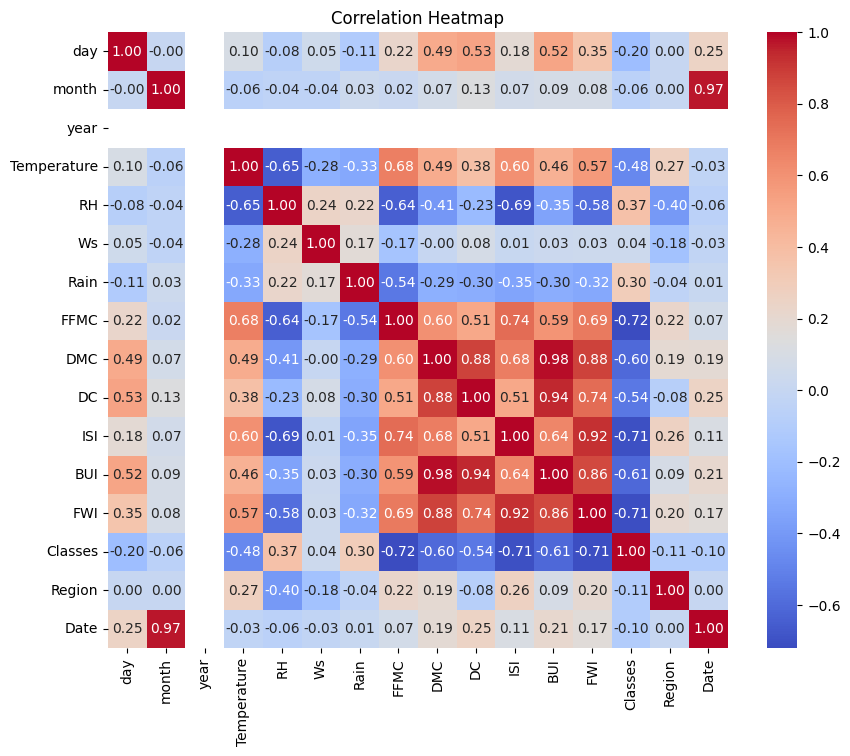

In [13]:
# Heatmap to understand the relationships between features and the target variable (FWI)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# Select relevant features based on correlation analysis
features = correlation_with_fwi[(correlation_with_fwi > 0.5) & (correlation_with_fwi < 1)].index.tolist()
print("Selected Features:", features)

target = 'FWI'
print("Target: ", target)

Selected Features: ['ISI', 'DMC', 'BUI', 'DC', 'Classes', 'FFMC', 'RH', 'Temperature']
Target:  FWI


**3. DATA VISUALIZATION**

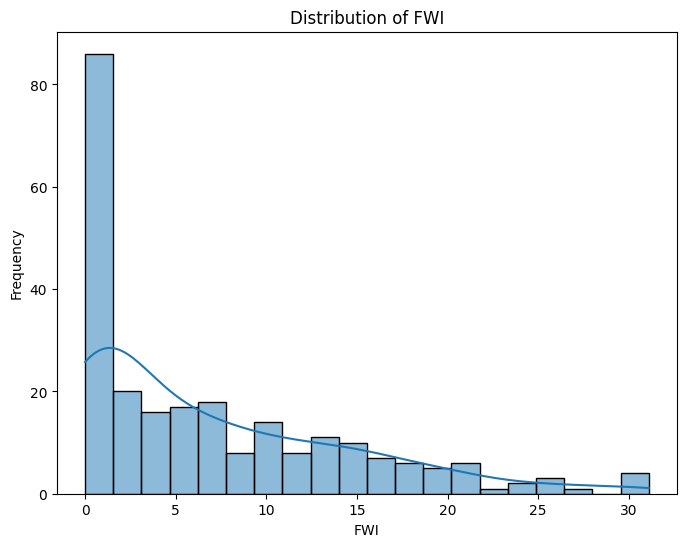

In [15]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(data['FWI'], bins=20, kde=True)
plt.title('Distribution of FWI')
plt.xlabel('FWI')
plt.ylabel('Frequency')
plt.show()

Most data points are at the lower end of the FWI scale. This means most days experience low fire danger (low FWI), while high FWI occur less frequently.

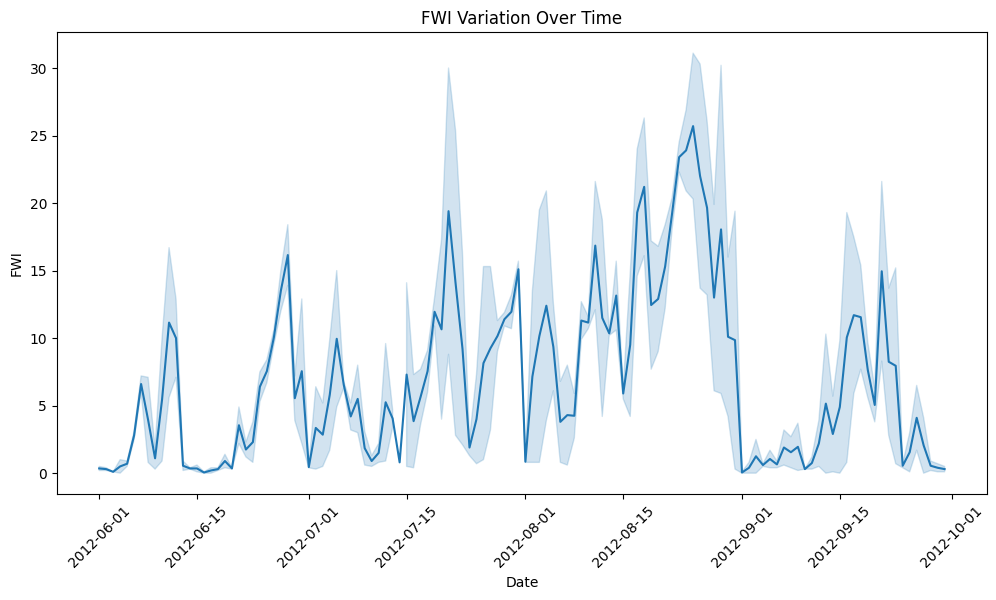

In [16]:
# Plot FWI variation over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='FWI', data=data)
plt.title('FWI Variation Over Time')
plt.xlabel('Date')
plt.ylabel('FWI')
plt.xticks(rotation=45)
plt.show()

it shows kind of cyclical patterns, suggesting seasonal influences. The shaded areas represent confidence intervals, indicating the variability in FWI measurements. Overall, this visualization helps to understand trends and potential fire risks  with changing weather conditions over the time.

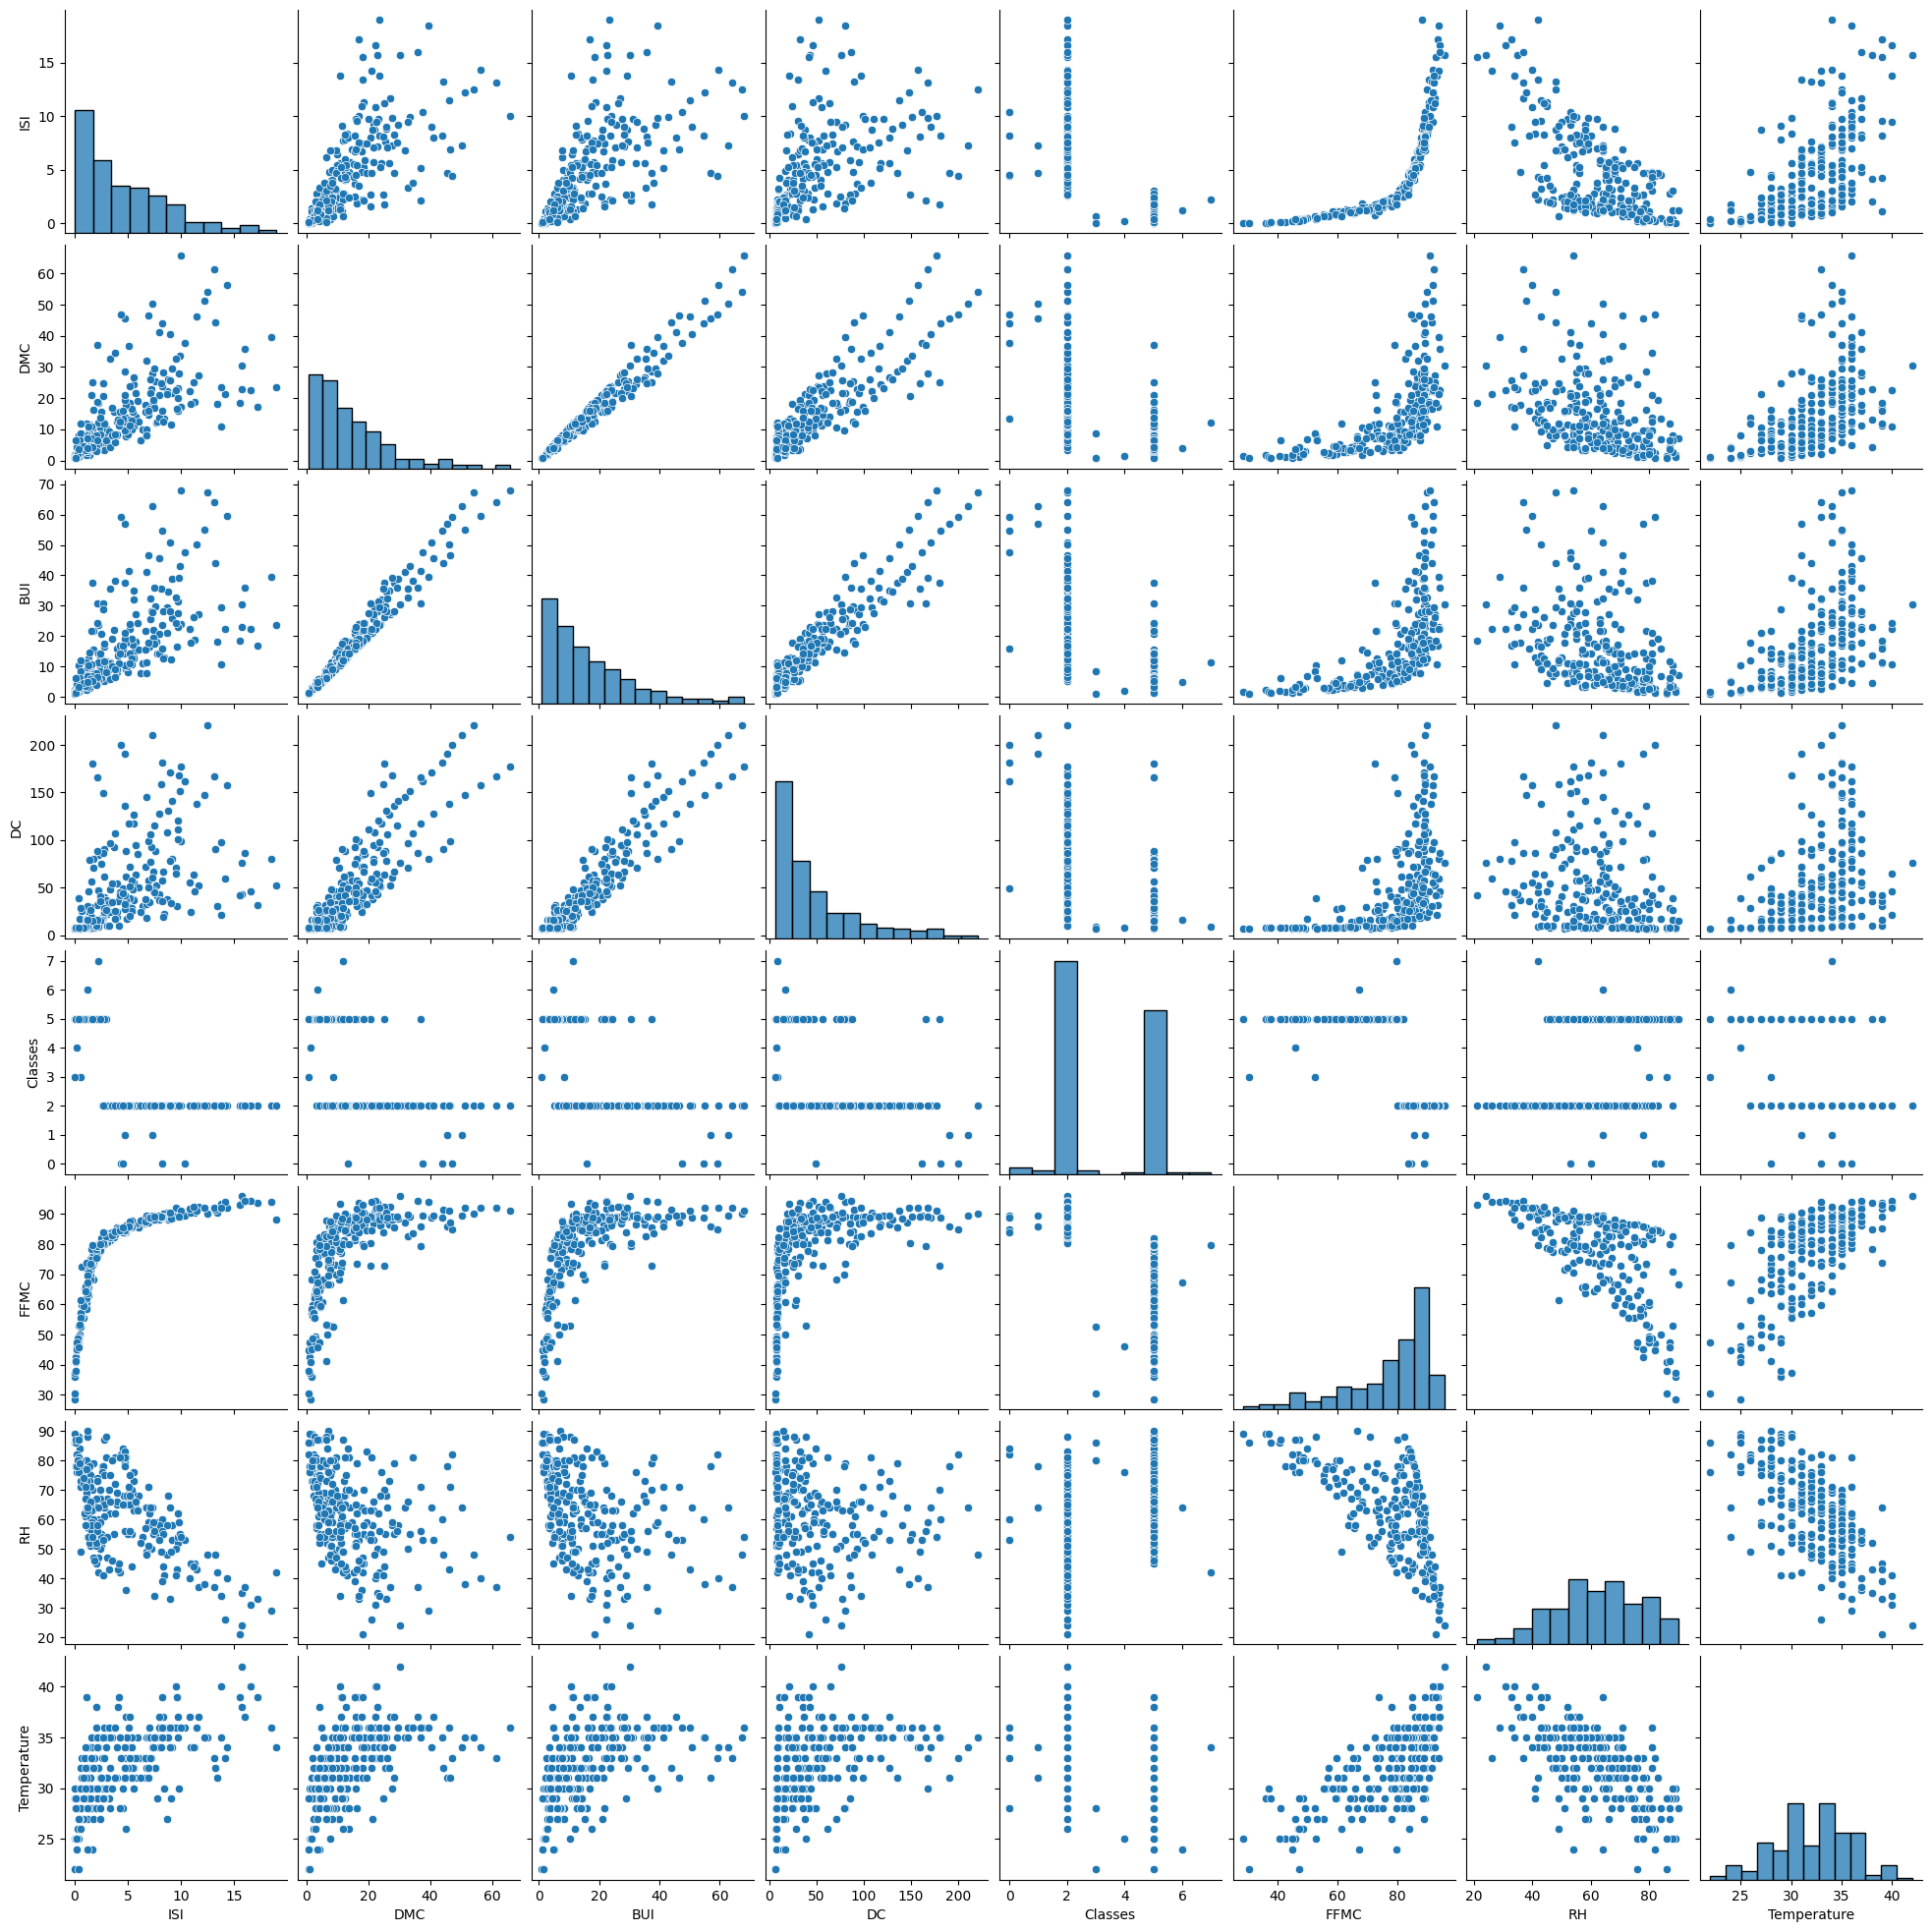

In [17]:
# Pairplot of Features
sns.pairplot(data, vars=features)
plt.show()

* each scatter plot within the matrix shows relation between two variables in x-axis and y-axis.
straight line clusters suggests a linear relationship between those variables. For example, the scatter plot between 'DMC', 'BUI' and 'DC' shows a positive correlation, indicating that as one of these indices increases, the others tend to increase as well. Overall, dry conditions are prevalent both at the surface and deeper layers, contributing to an overall high fire risk.

* The histograms along the diagonal display the distribution of individual variables.
histograms reveal that ISI, DMC, BUI, and DC exhibit right-skewed distributions, indicating a higher frequency of lower values. ie, majority of the recorded instances reflect less severe fire conditions, which could means moderate to low fuel availability or moisture levels.
The bar plot for classes shows the distribution of different fire occurrence categories.
The FFMC histogram shows that higher values are more common suggesting that fine fuel moisture content is often low, potentially due to dry conditions. RH also displays a distribution concentrated around higher values may means that the area generally experiences relatively humid conditions, while temperature values are primarily in the 20-30 range indicates a warm climate typically prone to fires.


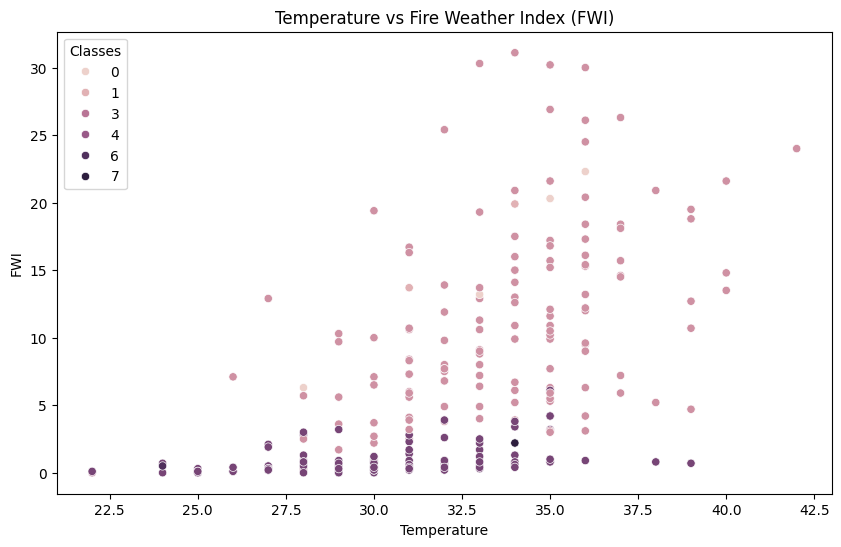

In [18]:
# Scatter plot: Temperature vs FWI
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Temperature'], y=data['FWI'], hue=data['Classes'])
plt.title('Temperature vs Fire Weather Index (FWI)')
plt.xlabel('Temperature')
plt.ylabel('FWI')
plt.show()

*The plot indicates that higher temperatures are associated with increased fire risk.
The classes color coded from 0 to 7 correspond to decrease in levels of fire danger or severity. when the temperature exceeds a certain level, the FWI sharply rises, indicating heightened fire risk.


**4. MODEL DEVELOPMENT AND ANALYSIS**

In [19]:
# Define features and target variable
X = data[features]
y = data[target]

In [21]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Evaluation function for calculating and printing MSE, RMSE, MAE, and R2 scores
def evaluate_model(model, X_test, y_test, name):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{name}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2) Score: {r2}")
    return mse, rmse, mae, r2

In [24]:
# Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
mlr_metrics = evaluate_model(mlr, X_test_scaled, y_test, "Multiple Linear Regression")

Multiple Linear Regression:
Mean Squared Error (MSE): 0.29104986412649547
Root Mean Squared Error (RMSE): 0.5394903744521263
Mean Absolute Error (MAE): 0.39594358438942834
R-squared (R2) Score: 0.9903970629347197


In [25]:
# Polynomial Regression using polynomial features of degree 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_scaled, y_train)
poly_metrics = evaluate_model(poly_model, X_test_scaled, y_test, f"Polynomial Regression (Degree={2})")

Polynomial Regression (Degree=2):
Mean Squared Error (MSE): 8.838235213960157
Root Mean Squared Error (RMSE): 2.9729169537610964
Mean Absolute Error (MAE): 0.6396747813917596
R-squared (R2) Score: 0.7083901180214414


In [26]:
# Lasso Regression
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, cv=5)             # Hyperparameter tuning is performed using GridSearchCV
lasso_grid.fit(X_train_scaled, y_train)
lasso_metrics = evaluate_model(lasso_grid, X_test_scaled, y_test, "Lasso Regression")
print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])

Lasso Regression:
Mean Squared Error (MSE): 0.5381604097988687
Root Mean Squared Error (RMSE): 0.7335941724133778
Mean Absolute Error (MAE): 0.5484164089421553
R-squared (R2) Score: 0.982243865456409
Best Lasso alpha: 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.996e+00, tolerance: 9.264e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e+00, tolerance: 9.824e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.734e+00, tolerance: 1.013e

In [27]:
# Ridge Regression
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_params, cv=5)             # Hyperparameter tuning is performed using GridSearchCV
ridge_grid.fit(X_train_scaled, y_train)
ridge_metrics = evaluate_model(ridge_grid, X_test_scaled, y_test, "Ridge Regression")
print("Best Ridge alpha:", ridge_grid.best_params_['alpha'])

Ridge Regression:
Mean Squared Error (MSE): 0.8760139389192347
Root Mean Squared Error (RMSE): 0.9359561629260393
Mean Absolute Error (MAE): 0.6634377602097407
R-squared (R2) Score: 0.9710966821819457
Best Ridge alpha: 10


In [28]:
# Decision Tree Regression
dt_params = {'max_depth': [3, 5, 7, 9, None]}
dt_grid = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_params, cv=5)
dt_grid.fit(X_train_scaled, y_train)
dt_metrics = evaluate_model(dt_grid, X_test_scaled, y_test, "Decision Tree Regression")
print("Best Decision Tree max_depth:", dt_grid.best_params_['max_depth'])

Decision Tree Regression:
Mean Squared Error (MSE): 2.035306122448979
Root Mean Squared Error (RMSE): 1.4266415535967607
Mean Absolute Error (MAE): 0.789795918367347
R-squared (R2) Score: 0.9328468451235473
Best Decision Tree max_depth: None


**Model comparison based on various evaluation metrics**

In [29]:
# Collecting all metrics for comparison
models_metrics = {
    "Multiple Linear Regression": mlr_metrics,
    "Polynomial Regression": poly_metrics,
    "Lasso Regression": lasso_metrics,
    "Ridge Regression": ridge_metrics,
    "Decision Tree Regression": dt_metrics
}

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(models_metrics, index=["MSE", "RMSE", "MAE", "R2"]).T
print("Model Comparison:\n", metrics_df)


Model Comparison:
                                  MSE      RMSE       MAE        R2
Multiple Linear Regression  0.291050  0.539490  0.395944  0.990397
Polynomial Regression       8.838235  2.972917  0.639675  0.708390
Lasso Regression            0.538160  0.733594  0.548416  0.982244
Ridge Regression            0.876014  0.935956  0.663438  0.971097
Decision Tree Regression    2.035306  1.426642  0.789796  0.932847


*multiple linear regression model performs very well, with high R-squared value indicating that it explains a large part of the variance in the target variable

*polynomial regression model shows a higher MSE and RMSE compared to the linear regression models, indicating higher prediction errors. R2 score suggests that the model explains around 70% of the variance in the target variable, which is lower than the linear regression models

*Lasso & ridge regression models performs well, with a high R-squared value and relatively low prediction errors

*decision tree regression model exhibits higher prediction errors compared to the linear regression models, as indicated by higher MSE, RMSE, and MAE. but still provides a reasonable predictive performance

*Overall, the multiple linear regression, Lasso regression, and Ridge regression models seem to perform the best among the evaluated models, with lower prediction errors and higher R2 values

**5. MODEL SAVING AND LOADING**

In [30]:
import pickle

# Save the trained models to pickle files
with open('mlr_model.pkl', 'wb') as f:
    pickle.dump(mlr, f)
with open('poly_model.pkl', 'wb') as f:
    pickle.dump(poly_model, f)
with open('lasso_model.pkl', 'wb') as f:
    pickle.dump(lasso_grid.best_estimator_, f)
with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(ridge_grid.best_estimator_, f)
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_grid.best_estimator_, f)

In [31]:
# Load the saved models again to test their performance on unseen data
with open('mlr_model.pkl', 'rb') as f:
    mlr_loaded = pickle.load(f)
with open('poly_model.pkl', 'rb') as f:
    poly_loaded = pickle.load(f)
with open('lasso_model.pkl', 'rb') as f:
    lasso_loaded = pickle.load(f)
with open('ridge_model.pkl', 'rb') as f:
    ridge_loaded = pickle.load(f)
with open('dt_model.pkl', 'rb') as f:
    dt_loaded = pickle.load(f)

In [32]:
# Evaluate each model
mlr_metrics = evaluate_model(mlr_loaded, X_test_scaled, y_test, "Multiple Linear Regression")
poly_metrics = evaluate_model(poly_loaded, X_test_scaled, y_test, "\nPolynomial Regression")
lasso_metrics = evaluate_model(lasso_loaded, X_test_scaled, y_test, "\nLasso Regression")
ridge_metrics = evaluate_model(ridge_loaded, X_test_scaled, y_test, "\nRidge Regression")
dt_metrics = evaluate_model(dt_loaded, X_test_scaled, y_test, "\nDecision Tree Regression")


Multiple Linear Regression:
Mean Squared Error (MSE): 0.29104986412649547
Root Mean Squared Error (RMSE): 0.5394903744521263
Mean Absolute Error (MAE): 0.39594358438942834
R-squared (R2) Score: 0.9903970629347197

Polynomial Regression:
Mean Squared Error (MSE): 8.838235213960157
Root Mean Squared Error (RMSE): 2.9729169537610964
Mean Absolute Error (MAE): 0.6396747813917596
R-squared (R2) Score: 0.7083901180214414

Lasso Regression:
Mean Squared Error (MSE): 0.5381604097988687
Root Mean Squared Error (RMSE): 0.7335941724133778
Mean Absolute Error (MAE): 0.5484164089421553
R-squared (R2) Score: 0.982243865456409

Ridge Regression:
Mean Squared Error (MSE): 0.8760139389192347
Root Mean Squared Error (RMSE): 0.9359561629260393
Mean Absolute Error (MAE): 0.6634377602097407
R-squared (R2) Score: 0.9710966821819457

Decision Tree Regression:
Mean Squared Error (MSE): 2.035306122448979
Root Mean Squared Error (RMSE): 1.4266415535967607
Mean Absolute Error (MAE): 0.789795918367347
R-squared (

In [33]:
# Collecting all metrics for comparison
models_metrics = {
    "Multiple Linear Regression": mlr_metrics,
    "Polynomial Regression": poly_metrics,
    "Lasso Regression": lasso_metrics,
    "Ridge Regression": ridge_metrics,
    "Decision Tree Regression": dt_metrics
}

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(models_metrics, index=["MSE", "RMSE", "MAE", "R2"]).T
print("Model Comparison:\n", metrics_df)


Model Comparison:
                                  MSE      RMSE       MAE        R2
Multiple Linear Regression  0.291050  0.539490  0.395944  0.990397
Polynomial Regression       8.838235  2.972917  0.639675  0.708390
Lasso Regression            0.538160  0.733594  0.548416  0.982244
Ridge Regression            0.876014  0.935956  0.663438  0.971097
Decision Tree Regression    2.035306  1.426642  0.789796  0.932847
